## Install rapidsai and *cuml*

In [ ]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/env-check.py

In [ ]:
# This will update the Colab environment and restart the kernel.  Don't run the next cell until you see the session crash.
!bash rapidsai-csp-utils/colab/update_gcc.sh
import os
os._exit(00)

In [ ]:
# This will install CondaColab.  This will restart your kernel one last time.  Run this cell by itself and only run the next cell once you see the session crash.
import condacolab
condacolab.install()

In [ ]:
# you can now run the rest of the cells as normal
import condacolab
condacolab.check()

In [ ]:
# Installing RAPIDS is now 'python rapidsai-csp-utils/colab/install_rapids.py <release> <packages>'
# The <release> options are 'stable' and 'nightly'.  Leaving it blank or adding any other words will default to stable.
!python rapidsai-csp-utils/colab/install_rapids.py stable
import os
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'
os.environ['CONDA_PREFIX'] = '/usr/local'
!pip uninstall cupy -y

In [ ]:
!conda install_rapids cuml

In [ ]:
import cuml
from cuml.manifold import UMAP

## Google colab stuff

In [ ]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/drive')  # This will prompt for authorization

In [ ]:
# Check memory
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print(f'Your runtime has {ram_gb:.1f} gigabytes of available RAM\n')

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

In [ ]:
# Check GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [ ]:
!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

## File for modeling

In [2]:
# !pip3 install bertopic
# !pip3 install openTSNE
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import hdbscan
from hdbscan import HDBSCAN
from openTSNE import TSNE as oTSNE
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

## Embeddings

In [ ]:
# Word embeddings
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")

sports_embeddings_256 = sentence_model.encode(docs, convert_to_numpy=True)

np.save('/content/drive/MyDrive/sports_embeddings_256', sports_embeddings_256)

In [ ]:
# load sentence data set 
transcripts = pd.read_csv('/content/drive/MyDrive/sport_sent_1.csv.gz', compression='gzip', usecols=[2])
print(transcripts.shape)
print(transcripts.head(2))

docs = transcripts.transcript_subset.to_list()
print(len(docs))

# Sentence embeddings
sports_embeddings_sentence_1 = sentence_model.encode(docs, convert_to_numpy=True)

np.save('/content/drive/MyDrive/sports_embeddings_sentence_1', sports_embeddings_sentence_1)

In [ ]:
# Initialize and rescale PCA embeddings and dim reduce using t-SNE, save dim reduced embeddings and embedding class object
PCA = PCA(n_components=50)
TSNE = oTSNE(n_components=3, verbose=True)

PCA_embeddings = PCA.fit_transform(embeddings_256)

# dim reduce and save t-SNE class object for prediciton
with open('tsne_data.pkl', 'wb') as outp:  # OBS create pkl file in dir
    tsne_dimreduced_embeddings = TSNE.fit(PCA_embeddings)
    pickle.dump(tsne_dimreduced_embeddings, outp, pickle.HIGHEST_PROTOCOL)

# save embeddings
np.save('/content/drive/MyDrive/tsne_dimred_embeddings', tsne_dimreduced_embeddings)

## Implement BERTopic like pipeline

### HDBSCAN

In [3]:
# Load data and embeddings 
modelling_data = pd.read_csv('sports_word_256.csv.gz', compression='gzip', usecols=[2])
modelling_documents = modelling_data.transcript_subset.to_list()

modelling_tsne_data = np.load('tsne_dimred_embeddings.npy')

In [34]:
hdbscan_model = HDBSCAN(
    min_cluster_size = 73,
    metric='euclidean', # same as cosine for normalised data
    cluster_selection_method='eom', 
    algorithm='best',
    prediction_data=True)

# save hdbscan as pickle for downstream transfer 
with open('hdbscan_model.pkl', 'wb') as outp:  # OBS create pkl file in dir
    hdbscan_model.fit(modelling_tsne_data)
    pickle.dump(hdbscan_model, outp, pickle.HIGHEST_PROTOCOL)

### Tokeniser and Weighting scheme

In [6]:
# we need to treat all documents of each cluster as a single document and get the BoW representations for each cluster
# Create df with cluster labels and coresponding docs 

cluster_df = pd.DataFrame({'document':modelling_documents, 'cluster_label': hdbscan_model.labels_})
cluster_df_no_outliers = cluster_df[cluster_df.cluster_label != -1]

# create concatenated documents for each cluster
cluster_labels = cluster_df_no_outliers.cluster_label.unique()

docu_ls = []
for label in cluster_labels:
    temp_df = cluster_df_no_outliers[cluster_df_no_outliers.cluster_label == label]
    document = ''.join(temp_df.document.to_list())
    docu_ls.append(document)

cluster_document_df = pd.DataFrame({'cluster': cluster_labels, 'cluster_document': docu_ls})

print(cluster_document_df.shape)

(461, 2)


In [ ]:
# TfidfVectorizer combines count vectoriser and tfidf transformer 
vectorizer = TfidfVectorizer(
    max_df=0.75,
    min_df=5,
    stop_words="english",
    norm = 'l1',
    ngram_range = (1, 2), # allow bigrams
    use_idf=True
)
X_tfidf = vectorizer.fit_transform(cluster_document_df.cluster_document.to_list())

print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")
print(f"non-zero entries in sparse matrix: {X_tfidf.nnz / np.prod(X_tfidf.shape):.2%}")

In [8]:
# extract index of the top n words with the highest tf-idf score for each topic
top_n = 20
X_tfidf_np = X_tfidf.toarray().transpose()
topic_representation_indexes = np.argpartition(X_tfidf_np, top_n*-1, axis=0)[top_n*-1:].transpose()
topic_representation_indexes_df = pd.DataFrame(topic_representation_indexes)

# build an indexer for looking up the word of the index in previous dataframe
word_indexer = pd.DataFrame({'position': list(vectorizer.vocabulary_.values()), 
                             'word':list(vectorizer.vocabulary_.keys())}).set_index('position').sort_index()

In [9]:
# Find the n representative words of each topic by looping through topic_representation_indexes_df and indexing word_indexer
topic_representations = []
for _, row in topic_representation_indexes_df.iterrows():
    topic_representation = []
    for i in list(row):
        topic_representation.append(word_indexer.word[i])
    topic_representations.append(topic_representation)


topic_reps = pd.DataFrame(topic_representations)
print(topic_reps.shape)

(461, 20)


### Topic representation tuning with GPT-3

In [67]:
import openai

with open('api_key.txt', 'r') as file:
    my_api_key = file.read()


openai.api_key = my_api_key

topic_rep = topic_reps.iloc[320].to_list()

gpt_prompt =f"""
I have a topic that is described by the following keywords:{topic_rep}.

Based on the information above, describe the topic in 4 words.
"""

message_array = [{'role':'user', 
                 'content': gpt_prompt}]

response = openai.ChatCompletion.create(
  model="gpt-3.5-turbo",
  messages=message_array,
  temperature=0.5,
  top_p=1.0,
  max_tokens=30,
  presence_penalty= -0.5, # increase the probability of using the same words as in the prompt
  frequency_penalty= -0.5 # increase the probability of using the same words as in the prompt
)

print(response.choices[0].message['content'])

Basketball rules and officiating.


## Topic model investigation

In [35]:
# HDBSCAN results dataframe
hdbscan_df = pd.DataFrame({'transcript': modelling_documents, 
                           'cluster_label':hdbscan_model.labels_})

# HDBSCAN results dataframe without outliers
hdbscan_df_noout = hdbscan_df[hdbscan_df.cluster_label != -1]

In [36]:
print(f'Number of topics: {len(hdbscan_df.cluster_label.unique())}')
print(f'Number of outliers: {len(hdbscan_df)- len(hdbscan_df_noout)}')

Number of topics: 257
Number of outliers: 156521


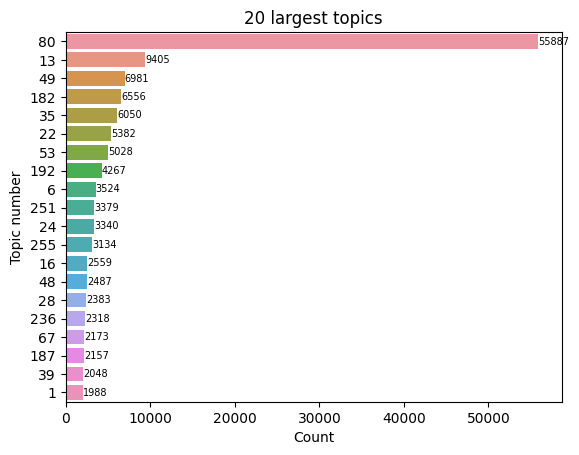

In [37]:
# cluster distribution
top_clusters = hdbscan_df_noout.cluster_label.value_counts().head(20)
ax = sns.barplot(x=top_clusters.values, y=top_clusters.index, orient='h', order=top_clusters.index)
ax.set_ylabel('Topic number')
ax.set_xlabel('Count')
ax.set_title('20 largest topics')
plt.rcParams.update({'font.size': 7})  # decrease font size
ax.bar_label(ax.containers[0])
plt.rcParams.update({'font.size': 10})  # return to normal font size
plt.show()

## Deprecated code


In [ ]:
# Define submodels
#sentence_model = SentenceTransformer("all-MiniLM-L6-v2")

dim_model = BaseDimensionalityReduction()

hdbscan_model = HDBSCAN(
    min_cluster_size = 15,
    metric='euclidean', # same as cosine for normalised data
    cluster_selection_method='eom', 
    algorithm='boruvka_kdtree',
    prediction_data=True)

ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

vectorizer_model = CountVectorizer(stop_words='english')

In [ ]:
# Initialize BERTopic and run

from bertopic.dimensionality import BaseCluster

empty_cluster_model = BaseCluster()

topic_model = BERTopic(
    #embedding_model=sentence_model,
    umap_model=dim_model,
    hdbscan_model=empty_cluster_model,
    ctfidf_model=ctfidf_model,
    vectorizer_model = vectorizer_model,
    verbose=True  # progress bar
    )

topics = topic_model.fit_transform(modelling_documents, y = hdbscan_df.cluster_labels)

In [ ]:
topic_model.save('BERT_v1') 

In [ ]:
len(topic_model.get_topics())